In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier
import math
import scipy.stats as stats
import statsmodels.api as sm
import pylab as pl

In [6]:
alldata = pd.read_csv('allmodel_denovo.csv', sep = '\t')

In [7]:
alldata

,location,SIFT_pred,LRT_pred,MA_pred,PROVEN_pred,SLR_score,SIFT_score,LRT_omega,MA_score,PROVEN_score,...,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,MPC,primateAI,source,result
0,chr1-909368-909369-G-A,0,0,0,0,0.017887,-0.131771,-0.020771,-1.445971,1.096942,...,0.006359,0.007,0.000953,0.230077,8.064,0.769905,0.009648,0.376979,0,0
1,chr1-949780-949781-G-A,0,0,0,0,0.669956,-0.248541,-0.017137,-0.552930,0.746700,...,0.022658,0.105,0.010884,0.579442,14.870,0.972044,0.323833,0.293253,0,0
2,chr1-949850-949851-G-C,1,0,0,0,0.017887,-0.466967,-0.002654,-1.445971,1.177205,...,0.002278,0.012,0.004718,0.453055,0.014,0.671454,0.295142,0.312391,0,0
3,chr1-955676-955677-A-C,1,0,1,0,0.017887,-0.619453,-0.028677,0.107775,0.567931,...,0.732046,0.270,0.169499,0.873813,23.000,0.990862,0.457945,0.942415,0,0
4,chr1-957604-957605-G-A,1,0,1,0,-0.972068,-0.619453,-0.028677,0.144078,0.301602,...,0.235624,0.796,0.980166,0.939406,24.600,0.998404,1.266766,0.707299,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,chrX-152087575-152087576-G-A,1,0,0,0,1.042752,-0.449129,0.002114,0.036865,0.463191,...,0.020687,0.100,0.780054,0.863714,22.500,0.998778,0.246865,0.376200,1,0
34295,chrX-152823731-152823732-G-C,0,1,0,0,-1.707224,0.030325,-0.028005,-1.972370,0.116006,...,0.293518,0.623,0.934660,0.985301,22.500,0.997626,1.533473,0.844758,1,0
34296,chrX-153184736-153184737-G-A,1,0,1,1,0.005868,-0.624354,-0.028005,0.868574,-1.730660,...,0.101583,0.363,0.992261,0.960404,32.000,0.999141,1.405771,0.674641,1,0
34297,chrX-153281946-153281947-C-T,1,0,1,1,0.478370,-0.605629,-0.024589,0.203206,-0.321099,...,0.136988,0.272,0.737025,0.964504,21.800,0.997202,1.281132,0.501935,1,0


In [51]:
original_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver',
                   'RNA_seq','UNEECON']

# the features for comparison (to other supervised score)
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score', 'MPC', 'primateAI']

x_column  = original_column + ['M-CAP_score', 'REVEL_score', 'MPC', 'primateAI']
y_column = 'source'


def transfer_log1(df, x_col, y_col):
    
    originaldata = df[df['source'] == 0]
    denovo = df[df['source'] ==1] 

    y = originaldata.loc[:,[y_col]].values.flatten()
    X = originaldata.loc[:,x_col]

    X_denovo = denovo.loc[:,x_col]
    y_denovo = denovo.loc[:,[y_col]].values.flatten()

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    Xtrain_denovo, Xtest_denovo, ytrain_denovo, ytest_denovo = train_test_split(X_denovo,y_denovo, test_size = 0.3, random_state = 42)


    X_train = pd.concat([X_train, Xtrain_denovo], join= 'inner')
    y_train = np.concatenate((y_train, np.full((1,Xtrain_denovo.shape[0]),1).flatten())).flatten()

    X_test = pd.concat([X_test, Xtest_denovo], join= 'inner')
    y_test = np.concatenate((y_test, np.full((1,Xtest_denovo.shape[0]),1).flatten())).flatten()

    regression = LogisticRegression(random_state = 42 , solver = 'lbfgs',max_iter = 150).fit(X_train, y_train)

    y_hat = regression.predict_proba(X_test)[:,1]
    
    print(X_train.shape, X_test.shape)  
    print()   
    
    print(Xtrain_denovo.shape,Xtest_denovo.shape) 
    print()  #
    
    #X_train, X_test, y_train, y_test, y_hat, regression = splitNfit(alldata, x_column, y_column, testsize = 0.3)
    drawROC(y_test, y_hat, title = 'predicting source (target data and source data)', lastone = True)
    
    coef_overall = regression.coef_.flatten()
    coefficient = pd.DataFrame({'regression':coef_overall}, index = x_col)
    print(abs(coefficient['regression']).sort_values())
    return(X_train, y_train, X_test,y_test, y_hat)
    

(24009, 34) (10290, 34)

(2960, 34) (1269, 34)



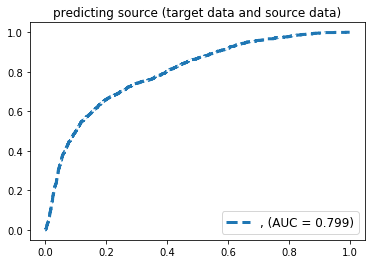

PredBFactorM      0.007523
PredStabilityL    0.009006
LRT_omega         0.010164
Grantham          0.011464
PredStabilityH    0.017530
PredBFactorS      0.026575
SLR_score         0.027103
PredBFactorF      0.032211
PredStabilityM    0.047413
LRT_pred          0.049650
HMMRelEntropy     0.049845
dscore            0.060193
phyloP_mam        0.095334
SIFT_score        0.140003
RNA_seq           0.143532
SIFT_pred         0.153437
PredRSAB          0.160142
PredRSAI          0.170486
phyloP_ver        0.191533
PROVEN_pred       0.202877
MPC               0.213827
phyloP_pri        0.214248
HMMEntropy        0.261776
PredSSC           0.315596
PredRSAE          0.329457
MA_score          0.415670
PROVEN_score      0.417778
MA_pred           0.418761
PredSSH           0.566652
primateAI         0.803338
UNEECON           0.907559
PredSSE           0.917526
M-CAP_score       2.580424
REVEL_score       4.509953
Name: regression, dtype: float64


In [37]:
transfer_log1(alldata, x_column, y_column)

(24009, 21) (10290, 21)

(2960, 21) (1269, 21)



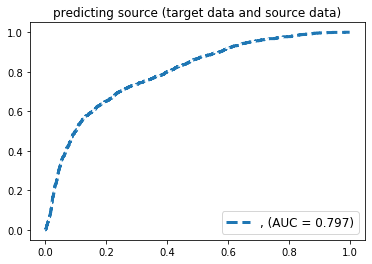

SIFT_score      0.138118
RNA_seq         0.141877
PredRSAB        0.143751
phyloP_ver      0.145203
SIFT_pred       0.165458
PredRSAI        0.188357
PROVEN_pred     0.195435
MPC             0.207797
HMMEntropy      0.213761
phyloP_pri      0.243537
PredSSC         0.302835
PredRSAE        0.333357
MA_pred         0.414590
MA_score        0.427960
PROVEN_score    0.433301
PredSSH         0.554571
primateAI       0.811166
PredSSE         0.903253
UNEECON         0.908434
M-CAP_score     2.591726
REVEL_score     4.449346
Name: regression, dtype: float64


In [44]:
#remove last 5
original_test = ['SIFT_pred','MA_pred', 'PROVEN_pred',  'SIFT_score', 
                'MA_score', 'PROVEN_score', 'HMMEntropy','PredRSAB', 'PredRSAI', 
                'PredRSAE', 
                 'PredSSE', 'PredSSH','PredSSC',  'phyloP_pri','phyloP_ver',
                   'RNA_seq','UNEECON']

# the features for comparison (to other supervised score)
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score', 'MPC', 'primateAI']

x_column  = original_test + ['M-CAP_score', 'REVEL_score', 'MPC', 'primateAI']
transfer_log1(alldata, x_column, y_column)

(24009, 3) (10290, 3)

(2960, 3) (1269, 3)



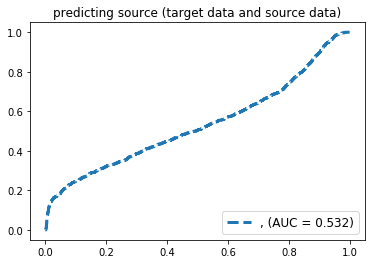

PredSSE      0.034706
UNEECON      0.208168
primateAI    1.200115
Name: regression, dtype: float64


In [113]:
#top 5
top = transfer_log1(alldata, ['MPC','UNEECON','PredSSE','primateAI'], y_column)

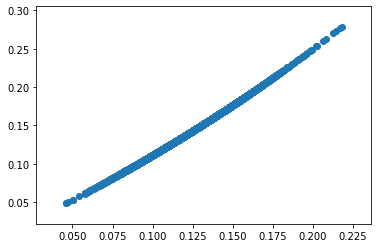

In [88]:
#clinvar + DDD
instance_weight = top[4]/(1-top[4])
instance_weight = instance_weight[:top[2].shape[0]]

# remove testing data that come from denovo set
ytest_denovo.shape 
#only clinvar
instance_weight_new = instance_weight[:9021]
instance_weight_new.shape #10290


y_hat_new = top[4][:9021]

plt.scatter(y_hat_new, instance_weight_new)
plt.show()
#plt.plot(instance_weight)
plt.show()
#np.count_nonzero(np.around(instance_weight))


(array([8.247e+03, 5.550e+02, 1.280e+02, 4.900e+01, 2.800e+01, 7.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00]),
 array([2.31737872e-03, 3.11271571e-01, 6.20225763e-01, 9.29179956e-01,
        1.23813415e+00, 1.54708834e+00, 1.85604253e+00, 2.16499672e+00,
        2.47395092e+00, 2.78290511e+00, 3.09185930e+00]),
 <a list of 10 Patch objects>)

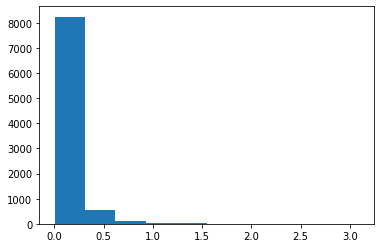

In [73]:
plt.hist(instance_weight_new)

In [90]:
#compute class weight
originaldata = alldata[alldata['source'] == 0] #46787
denovo = alldata[alldata['source'] ==1] 

Xtrain_denovo.shape

Xtrain.shape
classweight = {1:Xtrain.shape[0]/(Xtrain_denovo.shape[0]+Xtrain.shape[0]), 0:Xtrain_denovo.shape[0]/(Xtrain_denovo.shape[0]+Xtrain.shape[0])}

In [63]:
classweight

{1: 0.8767128993294181, 0: 0.12328710067058186}

In [66]:
ytest.shape

(9021,)

In [99]:
# training data here

#x_column = ['REVEL_score', 'M-CAP_score','UNEECON','PredSSE', 'primateAI']
x_column  = ['MPC','UNEECON','PredSSE','primateAI']
X = originaldata.loc[:,x_column]
y = originaldata.loc[:,['result']].values.flatten()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 42)

denovo = pd.read_csv('denovo_data.csv', sep = '\t')
X_test_denovo = denovo.loc[:,x_column]
y_test_denovo = denovo.loc[:,['result']].values.flatten()


# fit denovo data using training data with instance weight
transfer_LGR = LogisticRegression(random_state = 42 , solver = 'lbfgs', class_weight = classweight).fit(Xtest, ytest, sample_weight = instance_weight_new)
y_hat_denovo = transfer_LGR.predict_proba(X_test_denovo)[:,1]

LGR = LogisticRegression(random_state = 42 , solver = 'lbfgs').fit(Xtest, ytest)
y_hat_denovo_ori = LGR.predict_proba(X_test_denovo)[:,1]

LGR2 = LogisticRegression(random_state = 42 , solver = 'lbfgs',max_iter = 150).fit(Xtrain, ytrain)
y_hat_denovo_ori2 = LGR2.predict_proba(X_test_denovo)[:,1]

In [100]:
coef_overall = transfer_LGR.coef_.flatten()
coefficient = pd.DataFrame({'regression':coef_overall}, index = x_column)
coefficient['regression'].sort_values()

PredSSE      0.554200
MPC          0.825971
UNEECON      1.306826
primateAI    1.908751
Name: regression, dtype: float64

In [106]:
alldata[['MPC','UNEECON']]


,MPC,UNEECON
0,0.009648,-0.890704
1,0.323833,-0.831608
2,0.295142,-0.891344
3,0.457945,-0.652195
4,1.266766,-0.322466
...,...,...
34294,0.246865,0.029321
34295,1.533473,0.193517
34296,1.405771,0.367558
34297,1.281132,0.488870


In [111]:
np.corrcoef(alldata['MPC'], alldata['UNEECON'])[1][0]  #0.73
np.corrcoef(alldata['primateAI'], alldata['UNEECON'])[1][0] #0.66
np.corrcoef(alldata['primateAI'], alldata['MPC'])[1][0] #0.62

0.6204394322829022

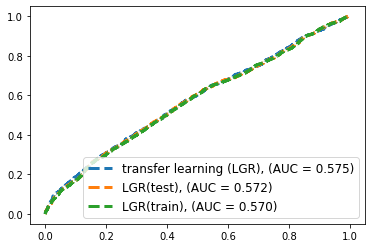

In [77]:
drawROC(y_test_denovo, y_hat_denovo, label = 'transfer learning (LGR)')
drawROC(y_test_denovo, y_hat_denovo_ori, label = 'LGR(test)')
drawROC(y_test_denovo, y_hat_denovo_ori2, label = 'LGR(train)', lastone = True)


In [78]:
def enrichment(df, portion, features, log = True, plot = True):
    num = int(df.shape[0]*portion*0.01)
    oddsratios = []
    errors = []
    for i in features:
    
        df[i] = pd.to_numeric(df[i])
        top = np.sum(df.nlargest(num,i)['result']) 
        array1 = [top, num-top]
              
        tail = np.sum(df.nsmallest(df.shape[0]-num,i)['result'])
        array2 = [tail, df.shape[0]-num-tail]

        
        result = sm.stats.Table2x2(np.asarray([array1, array2])).oddsratio
    
        if(log == True):
            result = math.log2(result)
            #result = math.log(result)
        #print(result)
        oddsratios.append(result)

        # check
        #print((top/(num-top))/(tail/(df.shape[0]-num-tail)))
        

        # change of base
        error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))* math.log2(math.e)
        #error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))
        errors.append(error)
     
    # Build the plot
    if(plot == True):
        fig, sub = plt.subplots(figsize=(18, 7))
    
        sub.bar(features, oddsratios,yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=5)
   
        plt.ylabel("log2 enrichment of proband denovo data")
    
        plt.title("enrichment test, enrichment level = %s percent"%portion)
    
        plt.show()
            
    return(oddsratios, np.asarray([array1,array2]))    


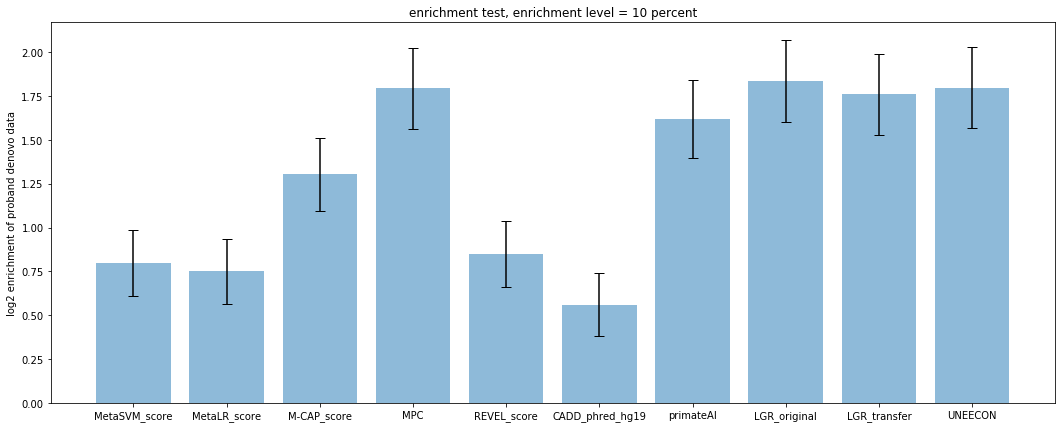

([0.7985770495863673,
  0.7508025788938524,
  1.302620100256085,
  1.7939876983197751,
  0.8472001751490479,
  0.5599316239068575,
  1.61855566831108,
  1.8331504758085617,
  1.7591187364047565,
  1.7957991853248496],
 array([[ 376,   46],
        [2672, 1135]]))

In [101]:
features = ['MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'MPC','REVEL_score','CADD_phred_hg19','primateAI']

denovo['LGR_original'],denovo['LGR_transfer'] = [y_hat_denovo_ori,y_hat_denovo]

features = features + ['LGR_original', 'LGR_transfer', 'UNEECON']

enrichment(denovo,10, features)

In [75]:
denovo[['our_model','LGR_transfer']]

,our_model,LGR_transfer
0,0.953930,0.125232
1,-1.322858,0.019479
2,-1.945298,0.004796
3,-2.947545,0.004680
4,-1.404344,0.016560
...,...,...
5980,-0.066988,0.092738
5981,-2.683431,0.007082
5982,-1.131317,0.008011
5983,-2.846104,0.008747


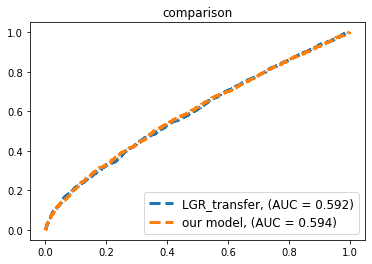

In [241]:

print(enrichment(denovo, 10, ['LGR_transfer'], plot = False))
enrichment(denovo, 10, ['our_model'], plot = False)
drawROC(y_test_denovo, y_hat_denovo, label = 'LGR_transfer')
drawROC(denovo_gb[0], denovo_gb [1], label = 'our model', lastone = True, title = 'comparison')

In [79]:
# gb + sample weight


Xtraindb, Xtestdb, ytraindb, ytestdb = train_test_split(X,y, test_size = 0.3, random_state = 42)


tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}

tuning(Xvalid, yvaliddb, 'gradient boosting', tuned_parameters)




# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
With score : 0.870

Grid scores on development set:

0.870 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.868 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.867 (+/-0.014) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.857 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.858 (+/-0.011) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.856 (+/-0.005) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.852 (+/-0.001) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.856 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.859 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.864 (+/-0.006) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.863 (+/-0.001) for 

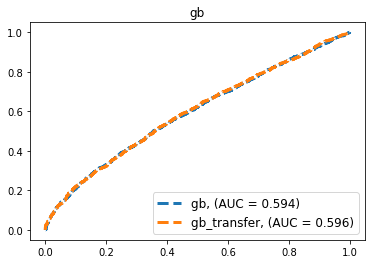

In [153]:
denovo_gb_transfer = GradientBoosting = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 3, n_estimators = 100, subsample = 1)
denovo_gb_transfer = denovo_gb_transfer.fit(Xtestdb, ytestdb, sample_weight = instance_weight_new)
yhat_gb_transfer = denovo_gb_transfer.decision_function(X_test_denovo)


drawROC(denovo_gb[0], denovo_gb[1], label = 'gb')
drawROC(y_test_denovo, yhat_gb_transfer, label = 'gb_transfer', lastone = True, title = 'gb')


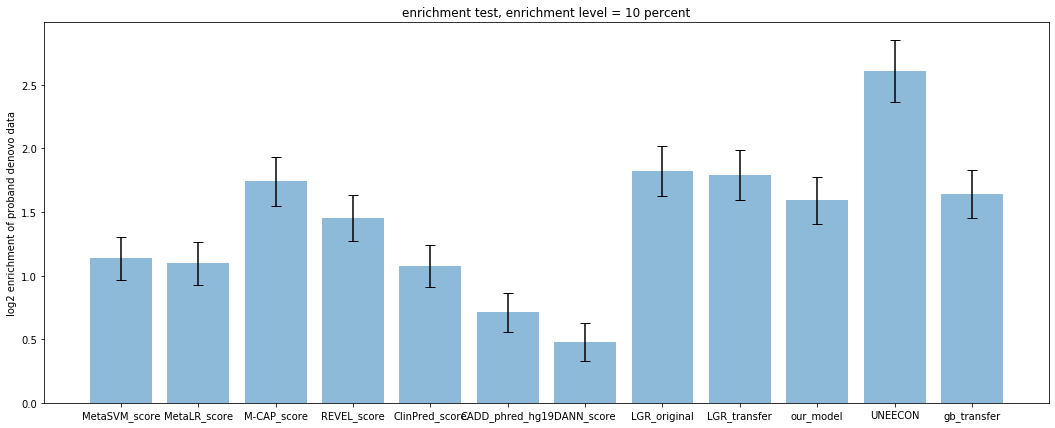

([1.1358827463279577,
  1.096848432033386,
  1.7408660086950296,
  1.4500995490997357,
  1.0775634858238041,
  0.7117291887539086,
  0.4787694421295965,
  1.8199683038704768,
  1.7932577377719028,
  1.5912078149529205,
  2.606006297511022,
  1.639914811778186],
 array([[ 528,   70],
        [3812, 1575]]))

In [154]:
features.append('gb_transfer')
denovo['gb_transfer'] = yhat_gb_transfer
enrichment(denovo,10, features)